In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%matplotlib inline

import sys, os, csv, datetime
from typing import Dict
parent_directory = os.path.split(os.getcwd())[0]
src_directory = os.path.join(parent_directory, 'src')
data_directory = os.path.join('/scratch/groups/gracegao', 'Google_GNSS_data')
ephemeris_data_directory = os.path.join(data_directory, 'ephemeris')
sys.path.insert(0, src_directory)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import hydra
from omegaconf import DictConfig, OmegaConf

import xarray as xr

In [107]:
import gnss_lib.coordinates as coord
import gnss_lib.sim_gnss as sg 
import gnss_lib.read_nmea as nmea
import gnss_lib.utils as utils 
import gnss_lib.solve_pos as solve_pos

from gnss_lib.constants import gpsconsts
from gnss_lib.coordinates import ecef2geodetic

from utils import *

from dataset.sim_dataset_seq import Sim_GNSS_Dataset_Seq
from correction_network.set_transformer_reduction import *
from correction_network.architectures import *

In [33]:
data_config = {
    "root": os.path.join(data_directory, "simulated_matlab_clockcorr_half_small_rebatched"),
    "measurement_dir" : "gnss_data",
    # "initialization_dir" : "initialization_data",
    # "info_path": "data_info.csv",
    "max_open_files": 10000,
    "guess_range": [15]*4 + [1e-5]*4,
    "history": 5,
    "seed": 0
        #TODO: Add all required parameters to the data_config file. Maybe set up data_config in train_conf.yaml?
    }

In [105]:
save_path = os.path.join(data_directory, "weights")
save_path = os.path.join(save_path, "8_10_22_0930_settfembed_rnn")

In [22]:
dataset = Sim_GNSS_Dataset_Seq(data_config, verbose=True)

Creating coordinates...


100%|██████████| 1781/1781 [00:00<00:00, 458173.17it/s]


Saving filenames and indexing...


100%|██████████| 1781/1781 [00:00<00:00, 2341.53it/s]


In [23]:
train_set, val_set = torch.utils.data.random_split(dataset, [int(0.9*len(dataset)), len(dataset) - int(0.9*len(dataset))])
    
print("Creating train and val dataloaders")
dataloader = DataLoader(train_set, batch_size=32,
                        shuffle=True, num_workers=0, collate_fn=collate_feat_sequential)
val_loader = DataLoader(val_set, batch_size=1, 
                        shuffle=False, num_workers=0, collate_fn=collate_feat_sequential)

Creating train and val dataloaders


In [108]:
# embedding = FullyConnectedNetwork(dim_input=4, max_sats=10, dim_output=16, batch_first=True)
# embedding = LearnedWLSEmbeddings(output_dim=16, batch_first=True, output_residual=False)
embedding = SetTransformerPointOutput(4, 4, 16, batch_first=True)

# net = SetTransformerPointOutput(4, 10, 4, dim_hidden=8, num_layers=[1, 4, 1, 4], num_heads=8, batch_first=True)     # define the network
# net = FullyConnectedNetwork(4, 10, 4, batch_first=True)
# net = LearnedWLS(10, batch_first=True)
# net = LearnedWLSSetTransformerCorrection(batch_first=True)
# net = BasicLS(batch_first=True)
# net = LearnedWLSEmbeddings(batch_first=True)
net = LearnedEmbeddingsRNN(embedding, batch_first=True, time_last=True)
net.cuda()

LearnedEmbeddingsRNN(
  (embedding): SetTransformerPointOutput(
    (feat_in): Sequential(
      (0): Linear(in_features=4, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
    )
    (enc_feat): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): PReLU(num_parameters=1)
    )
    (enc): TEB(
      (enc): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
            )
            (linear1): Linear(in_features=64, out_features=128, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (linear2): Linear(in_features=128, out_features=64, bias=True)
            (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (norm2): L

In [109]:
optimizer = torch.optim.Adam(net.parameters(), 3e-4)
loss_func = torch.nn.MSELoss(reduction='none')
count = 0
loss_arr = []

In [110]:
# checkpoint = torch.load(save_path)
# # net.embedding.load_state_dict(checkpoint['embedding'])
# # net.lstm.load_state_dict(checkpoint['lstm'])
# # net.fc.load_state_dict(checkpoint['fc'])
# # net.fc_dxt.load_state_dict(checkpoint['fc_dxt'])
# net.load_state_dict(checkpoint['net'])
# # optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
for epoch in tqdm(range(400)):
    # TRAIN Phase
    net.train()
    for i, sample_batched in enumerate(tqdm(dataloader)):
        _sample_batched, pad_mask = sample_batched

#         x = _sample_batched['sv_features'][:, :, 0, :].float().cuda()
#         y = _sample_batched['true_corrections'][:, :, 0].float().cuda()

        x = _sample_batched['sv_features'].float().cuda()
        y = _sample_batched['true_corrections'].float().cuda()
        dxt_feat = _sample_batched['pose_features'].float().cuda()
        mask_times = _sample_batched['mask_times'].cuda()
        
#         pad_mask = pad_mask[:, :, 0].cuda()
        pad_mask = pad_mask.cuda()
        pred_correction = net(x, dxt_feat, pad_mask=pad_mask, mask_times=mask_times)
        loss = loss_func(pred_correction, y)
        loss = (loss * torch.unsqueeze(mask_times.float(), 1)).sum()
        loss_arr.append(loss.item())

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
    # TEST Phase
    net.eval()

  8%|▊         | 4/51 [00:01<00:13,  3.40it/s]


 18%|█▊        | 9/51 [00:02<00:12,  3.41it/s]


 27%|██▋       | 14/51 [00:04<00:10,  3.39it/s]


 37%|███▋      | 19/51 [00:05<00:09,  3.43it/s]


 47%|████▋     | 24/51 [00:07<00:07,  3.44it/s]


 57%|█████▋    | 29/51 [00:08<00:06,  3.39it/s]


 67%|██████▋   | 34/51 [00:09<00:04,  3.41it/s]


 76%|███████▋  | 39/51 [00:11<00:03,  3.41it/s]


 86%|████████▋ | 44/51 [00:13<00:02,  3.39it/s]


 96%|█████████▌| 49/51 [00:14<00:00,  3.38it/s]


  4%|▍         | 2/51 [00:00<00:14,  3.35it/s]


 14%|█▎        | 7/51 [00:02<00:15,  2.89it/s]


 24%|██▎       | 12/51 [00:03<00:11,  3.38it/s]


 33%|███▎      | 17/51 [00:04<00:10,  3.38it/s]


 43%|████▎     | 22/51 [00:06<00:08,  3.38it/s]


  6%|▌         | 3/51 [00:00<00:14,  3.35it/s]

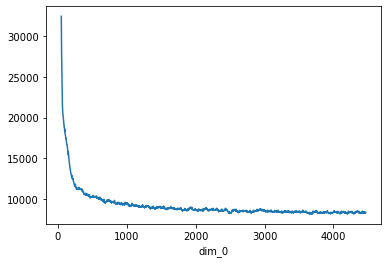

In [98]:
loss_xr = xr.DataArray(loss_arr)
loss_xr.rolling(dim_0=50).mean().plot()

In [99]:
net.eval()
T = data_config["history"]+1
out_pred = [[] for _ in range(T)]
out_true = [[] for _ in range(T)]


for i, sample_batched in enumerate(tqdm(val_loader, desc='val')):
    _sample_batched, pad_mask = sample_batched

    x = _sample_batched['sv_features'].float().cuda()
    y = _sample_batched['true_corrections'].float().cuda()
    dxt_feat = _sample_batched['pose_features'].float().cuda()
    mask_times = _sample_batched['mask_times'].cuda()

    pad_mask = pad_mask.cuda()
    pred_correction = net(x, dxt_feat, pad_mask=pad_mask, mask_times=mask_times)

    pred_correction = pred_correction.detach().cpu()
    y = y.detach().cpu()
    for t in range(T):
        if mask_times[0, t]:
            out_pred[t].append(pred_correction[0, :, t])
            out_true[t].append(y[0, :, t])

val: 100%|██████████| 179/179 [00:02<00:00, 86.19it/s]


In [100]:
out_pred = [torch.stack(_out_pred) for _out_pred in out_pred]
out_true = [torch.stack(_out_true) for _out_true in out_true]
sorted_idx = [[] for _ in range(T)]
for t in range(T):
    for i in range(4):
        sorted_idx[t].append(torch.argsort(out_true[t][:, i]))

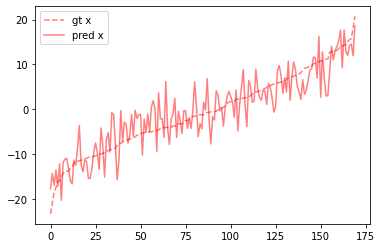

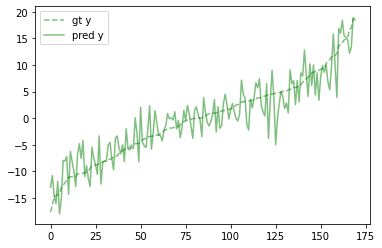

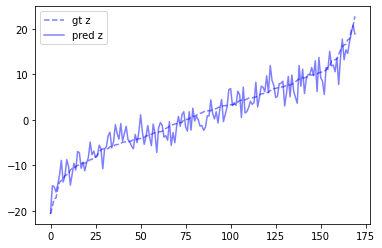

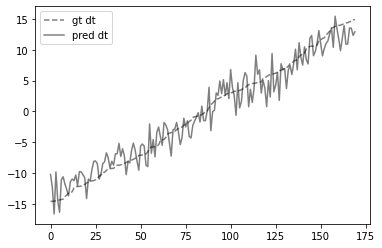

In [101]:
t = 5

plt.figure()
plt.plot(out_true[t][sorted_idx[t][0], 0], 'r--', label='gt x', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][0], 0], 'r', label='pred x', alpha=0.5)
plt.legend()

plt.figure()
plt.plot(out_true[t][sorted_idx[t][1], 1], 'g--', label='gt y', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][1], 1], 'g', label='pred y', alpha=0.5)
plt.legend()

plt.figure()
plt.plot(out_true[t][sorted_idx[t][2], 2], 'b--', label='gt z', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][2], 2], 'b', label='pred z', alpha=0.5)
plt.legend()

plt.figure()
plt.plot(out_true[t][sorted_idx[t][3], 3], 'k--', label='gt dt', alpha=0.5)
plt.plot(out_pred[t][sorted_idx[t][3], 3], 'k', label='pred dt', alpha=0.5)
plt.legend()

In [102]:
hist_diff = [(out_true[t]-out_pred[t]).numpy() for _ in range(T)]

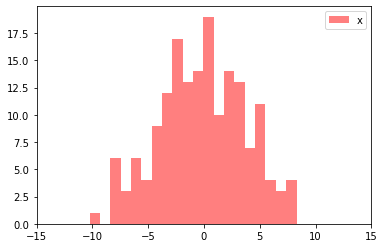

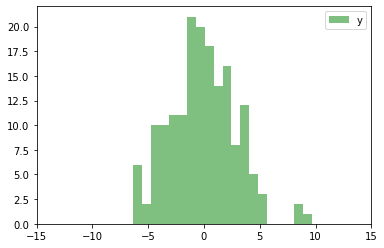

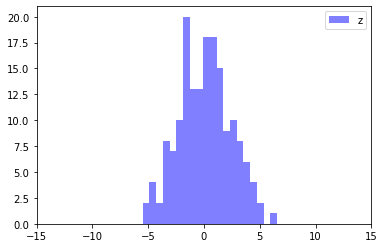

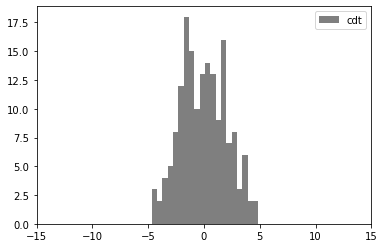

In [103]:
t=5

plt.figure()
plt.hist(hist_diff[t][:, 0], bins=20, alpha=0.5, label="x", color="r")
plt.xlim([-15, 15])
plt.legend()

plt.figure()
plt.hist(hist_diff[t][:, 1], bins=20, alpha=0.5, label="y", color="g")
plt.xlim([-15, 15])
plt.legend()

plt.figure()
plt.hist(hist_diff[t][:, 2], bins=20, alpha=0.5, label="z", color="b")
plt.xlim([-15, 15])
plt.legend()

plt.figure()
plt.hist(hist_diff[t][:, 3], bins=20, alpha=0.5, label="cdt", color="k")
plt.xlim([-15, 15])
plt.legend()

In [104]:
checkpoint = {
    'embedding': net.embedding.state_dict(),
    'lstm': net.lstm.state_dict(),
    'fc': net.fc.state_dict(),
    'fc_dxt': net.fc_dxt.state_dict(),
    'net': net.state_dict(),
    'optimizer': optimizer.state_dict(),
}

torch.save(checkpoint, save_path)